Cryptocurrency trading bot.

Hardcoded parameters.

In [1]:
traded_symbol = 'BNBBTC'
symbols = {'ETHBTC': None, 
           'BTCUSDT': None, 
           'ETHUSDT': None, 
           'BNBBTC': None, 
           'BNBETH': None, 
           'BNBUSDT': None}
percentage_to_trade = 0.99
interval = '1m'
window_1 = 1
window_2 = 1
period = '1 hour ago UTC'
api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None # This avoids SettingWithCopyWarnings

Function definitions.

In [4]:
def calculate_moving_average(dataset, window=2, method='simple'):
    if method == 'simple':
        dataset = dataset.rolling(window=window)
    elif method == 'exponential':
        dataset = dataset.ewm(span=window)

    dataset = dataset.mean()
    dataset = dataset.fillna(method='backfill', axis='index')
    return dataset

def calculate_renko(dataset, brick_size=1):
    renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
    renko_.index.name = 'date'
    renko_ = Renko(renko_.reset_index())
    renko_.brick_size = brick_size
    renko_ = renko_.get_ohlc_data().set_index('date')
    renko_.index.name = 'time'
    return renko_.uptrend

def calculate_heikin_ashi(df):
    df = df.tz_localize(tz=None, ambiguous='infer')
    df = df[['open', 'high', 'low', 'close']].copy().astype('float')
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

    return heikin_ashi_df

def calculate_RSI(ticker, span=14):
    up = ticker['close'].astype(float).pct_change()
    down = up.copy()
    up[up < 0.0] = 0.0
    down[down > 0.0] = 0.0

    up = up.ewm(span=span).mean().fillna(method='pad')
    down = down.ewm(span=span).mean().abs().fillna(method='pad')

    ticker = up / down
    ticker = 100 - (100 / (1 + ticker))

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = ticker.iloc[1]
    return ticker.fillna(method='pad')

def calculate_MACD(ticker, span1=12, span2=26, average='exponential'):
    if average == 'linear':
        shorter = ticker['close'].rolling(window=span1).mean()
        longer = ticker['close'].rolling(window=span2).mean()
    if average == 'exponential':
        shorter = ticker['close'].ewm(span=span1).mean()
        longer = ticker['close'].ewm(span=span2).mean()

    ticker = shorter - longer

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    ticker.iloc[0] = 0.0
    ticker = ticker.fillna(method='pad').to_frame(name='MACD')
    ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
    ticker['histogram'] = ticker.MACD - ticker.signal_line
    return ticker

def calculate_ATR(ticker, min_periods=14):
    ticker = ticker.astype(float)
    up = pd.DataFrame([ticker['high'].shift(), 
                       ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

    down = pd.DataFrame([ticker['low'].shift(), 
                         ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

    ticker = (up - down).ewm(alpha=1 / min_periods, 
                             min_periods=min_periods, 
                             adjust=False).mean()

    ticker = ticker.replace([-np.inf, np.inf], np.nan)
    return ticker.fillna(method='backfill')

def calculate_bollinger_bands(dataframe, period=20):
    df = dataframe.copy()
    df['MA'] = df['close'].rolling(period).mean()
    df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
    df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
    df['BB_width'] = df['BB_up'] - df['BB_down']
    df.dropna(inplace=True)
    return df

def calculate_average_directional_index(df, n, n_ADX):
    dataset_index = df.index.copy()
    df = df.reset_index().drop(columns=['time']).astype(float)
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'high'], df.loc[i, 'close']) - min(df.loc[i + 1, 'low'], df.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(), name='ADX')
    df = df.join(ADX)
    df.index = dataset_index
    return df.ADX.dropna()

def calculate_commodity_channel_index(dataset, min_periods=20):
    PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
    CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                    PP.rolling(min_periods, min_periods=min_periods).std(),
                    name='CCI')
    dataset = dataset.join(CCI)
    return dataset['CCI']

def calculate_KDJ(dataset):
    def get_rsv(dataset):
        low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
        high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
        return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

    def calc_kd(column):
        k = 50.0
        for i in (1.0 / 3.0) * column:
            k = (2.0 / 3.0) * k + i
            yield k

    dataset['K'] = list(calc_kd(get_rsv(dataset)))
    dataset['D'] = list(calc_kd(dataset['K']))
    dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
    return dataset[['K', 'D', 'J']]

def download_dataset(symbol=traded_symbol, interval=interval):
    dataset_downloaded = \
        client.get_historical_klines(symbol=symbol, 
                                     interval=interval, 
                                     start_str=period)

    dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                      columns=['time', 
                                               'open', 
                                               'high', 
                                               'low', 
                                               'close', 
                                               'volume', 
                                               'Close time', 
                                               'Quote asset volume', 
                                               'Number of trades', 
                                               'Taker buy base asset volume', 
                                               'Taker buy quote asset volume', 
                                               'Ignore'])

    four_hours = 14400
    milliseconds = 1000

    dataset_downloaded['time'] = \
        dataset_downloaded['time'].apply(lambda timestamp: \
                                         datetime.datetime.fromtimestamp((timestamp / \
                                                                          milliseconds) - \
                                                                         four_hours))

    dataset_downloaded = dataset_downloaded[['time', 
                                             'open', 
                                             'high', 
                                             'low', 
                                             'close', 
                                             'volume']]

    dataset_downloaded.set_index('time', inplace=True)
    dataset_downloaded = dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))
    return dataset_downloaded

class Cryptocurrency:
    def __init__(self, client, symbol, interval=interval):
        symbol_info = client.get_symbol_info(symbol)
        self.symbol = symbol
        self.interval = interval
        self.base_asset = symbol_info['baseAsset']
        self.quote_asset = symbol_info['quoteAsset']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'PRICE_FILTER'][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in client.get_symbol_info(symbol)['filters'] if ticker['filterType'] == 'LOT_SIZE'][0]
        self.base_asset_precision = client.get_symbol_info(symbol)['baseAssetPrecision']
        self.quote_asset_precision = client.get_symbol_info(symbol)['quotePrecision']
        self.dataset = download_dataset(symbol=symbol, interval=interval)
        self.calculate_indicators()
        self.calculate_balance()
        self.calculate_position()
        self.state = 'entry'

    def calculate_position(self):
        if self.base_asset_buy_balance > self.base_asset_sell_balance:
            self.position = 'sell'
        elif self.base_asset_sell_balance > self.base_asset_buy_balance:
            self.position = 'buy'

    def calculate_balance(self):
        self.quote_asset_buy_balance = float(client.get_asset_balance(asset=self.quote_asset)['free'])
        self.base_asset_buy_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.base_asset_buy_balance = self.quote_asset_buy_balance / self.base_asset_buy_last_price
        self.base_asset_sell_balance = float(client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_sell_last_price = float(client.get_ticker(symbol=self.symbol)['lastPrice'])
        self.quote_asset_sell_balance = self.base_asset_sell_balance * self.quote_asset_sell_last_price
        self.quote_asset_balance_combined = self.quote_asset_sell_balance + self.quote_asset_buy_balance
        self.base_asset_balance_combined = self.base_asset_buy_balance + self.base_asset_sell_balance

    def calculate_indicators(self):
        dataset = self.dataset.astype(float)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_1, method='simple')
        self.heikin_ashi = calculate_heikin_ashi(self.heikin_ashi)
        self.heikin_ashi = calculate_moving_average(dataset, window=window_2, method='exponential')
        self.RSI_6 = calculate_RSI(dataset, span=6)
        self.RSI_12 = calculate_RSI(dataset, span=12)
        self.CCI = calculate_commodity_channel_index(self.heikin_ashi, min_periods=20)
        self.brick_size = calculate_ATR(dataset, min_periods=14).median()
        self.renko = calculate_renko(dataset, brick_size=self.brick_size)
        self.ADX = calculate_average_directional_index(dataset, n=14, n_ADX=14)
        self.KDJ = calculate_KDJ(dataset)
        self.MACD = calculate_MACD(dataset)
        self.bollinger_bands = calculate_bollinger_bands(dataset, period=20)
        self.trend_trigger = (self.heikin_ashi['close'] - self.heikin_ashi['open']) > 0
        self.overtraded_trigger = self.RSI_6 > self.RSI_12
        self.trend_strength_trigger = self.ADX > 0.20
        self.momentum_trigger = self.KDJ['J'] > self.KDJ['D']
        self.volatility_trigger = (self.bollinger_bands['BB_width'] / dataset['close']) > 0.00045

    def print_balance(self):
        print('quote_asset_buy_balance: ', self.quote_asset_buy_balance)
        print('base_asset_buy_last_price: ', self.base_asset_buy_last_price)
        print('base_asset_buy_balance: ', self.base_asset_buy_balance)
        print('base_asset_sell_balance: ', self.base_asset_sell_balance)
        print('quote_asset_sell_last_price: ', self.quote_asset_sell_last_price)
        print('quote_asset_sell_balance: ', self.quote_asset_sell_balance)
        print('quote_asset_balance_combined: ', self.quote_asset_balance_combined)
        print('base_asset_balance_combined: ', self.base_asset_balance_combined)

    def trade(self):
        self.calculate_balance()

        if self.position == 'sell':
            coins_available = self.base_asset_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.base_asset_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.step_size) / float(10**self.step_size)

        if self.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.tick_size)) / float(abs(self.tick_size))

        client.create_order(symbol=self.symbol, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position

In [5]:
client = Client(api_key, api_secret)

In [6]:
for symbol in symbols.keys():
    symbols[symbol] = Cryptocurrency(client, symbol, interval)
    print(symbols[symbol].dataset)

                         open      high       low     close   volume
time                                                                
2020-04-26 17:02:00  0.025581  0.025594  0.025569  0.025571  233.646
2020-04-26 17:03:00  0.025573   0.02558  0.025573  0.025574   23.999
2020-04-26 17:04:00  0.025575  0.025578  0.025555  0.025563  117.671
2020-04-26 17:05:00  0.025559  0.025591  0.025559  0.025577  125.588
2020-04-26 17:06:00  0.025579  0.025581  0.025567  0.025581  162.468
2020-04-26 17:07:00  0.025576   0.02559  0.025566  0.025572   131.91
2020-04-26 17:08:00  0.025572  0.025601  0.025572  0.025601   85.676
2020-04-26 17:09:00  0.025602  0.025607  0.025581  0.025597   97.793
2020-04-26 17:10:00  0.025591  0.025593  0.025569  0.025573  116.223
2020-04-26 17:11:00  0.025572   0.02558  0.025564   0.02557  127.151
2020-04-26 17:12:00  0.025572  0.025579  0.025561  0.025574  103.663
2020-04-26 17:13:00  0.025574   0.02558  0.025567   0.02558  167.114
2020-04-26 17:14:00   0.02558  0.0

In [7]:
for symbol in symbols.keys():
    print(symbol)
    print(symbols[symbol].heikin_ashi)
    fig = go.Figure(data=[go.Candlestick(x=symbols[symbol].heikin_ashi.index.to_series(), 
                                         open=symbols[symbol].heikin_ashi['open'], 
                                         high=symbols[symbol].heikin_ashi['high'], 
                                         low=symbols[symbol].heikin_ashi['low'], 
                                         close=symbols[symbol].heikin_ashi['close'])])

    fig.show()

ETHBTC
                         open      high       low     close   volume
time                                                                
2020-04-26 17:02:00  0.025581  0.025594  0.025569  0.025571  233.646
2020-04-26 17:03:00  0.025573  0.025580  0.025573  0.025574   23.999
2020-04-26 17:04:00  0.025575  0.025578  0.025555  0.025563  117.671
2020-04-26 17:05:00  0.025559  0.025591  0.025559  0.025577  125.588
2020-04-26 17:06:00  0.025579  0.025581  0.025567  0.025581  162.468
2020-04-26 17:07:00  0.025576  0.025590  0.025566  0.025572  131.910
2020-04-26 17:08:00  0.025572  0.025601  0.025572  0.025601   85.676
2020-04-26 17:09:00  0.025602  0.025607  0.025581  0.025597   97.793
2020-04-26 17:10:00  0.025591  0.025593  0.025569  0.025573  116.223
2020-04-26 17:11:00  0.025572  0.025580  0.025564  0.025570  127.151
2020-04-26 17:12:00  0.025572  0.025579  0.025561  0.025574  103.663
2020-04-26 17:13:00  0.025574  0.025580  0.025567  0.025580  167.114
2020-04-26 17:14:00  0.0255

BTCUSDT
                        open     high      low    close       volume
time                                                                
2020-04-26 17:02:00  7748.94  7752.00  7745.00  7746.22    46.861160
2020-04-26 17:03:00  7747.07  7749.64  7742.61  7744.90    60.491144
2020-04-26 17:04:00  7744.90  7744.90  7736.26  7739.10    27.432877
2020-04-26 17:05:00  7739.06  7742.56  7737.18  7738.91    44.756492
2020-04-26 17:06:00  7739.65  7743.10  7739.00  7740.66    50.699773
2020-04-26 17:07:00  7740.21  7740.86  7732.58  7736.04    42.849397
2020-04-26 17:08:00  7736.04  7742.85  7735.61  7738.35    15.248624
2020-04-26 17:09:00  7738.28  7746.99  7735.09  7746.99    33.882650
2020-04-26 17:10:00  7746.99  7757.80  7746.01  7751.55    59.466241
2020-04-26 17:11:00  7751.56  7768.90  7751.56  7762.86    75.851953
2020-04-26 17:12:00  7763.00  7763.38  7753.42  7761.90   123.223711
2020-04-26 17:13:00  7761.96  7762.26  7756.63  7761.28    51.785598
2020-04-26 17:14:00  7760.

ETHUSDT
                       open    high     low   close      volume
time                                                           
2020-04-26 17:02:00  198.18  198.40  198.06  198.08   714.39488
2020-04-26 17:03:00  198.12  198.20  198.06  198.10   134.91981
2020-04-26 17:04:00  198.10  198.10  197.77  197.83   921.61368
2020-04-26 17:05:00  197.85  198.09  197.85  197.92   448.81077
2020-04-26 17:06:00  197.92  198.06  197.91  197.99   246.13095
2020-04-26 17:07:00  197.98  197.98  197.80  197.80   336.90048
2020-04-26 17:08:00  197.86  198.14  197.86  198.11   401.48421
2020-04-26 17:09:00  198.08  198.22  197.90  198.22   177.98898
2020-04-26 17:10:00  198.21  198.35  198.20  198.24   850.47815
2020-04-26 17:11:00  198.23  198.59  198.23  198.58  1281.47599
2020-04-26 17:12:00  198.52  198.58  198.23  198.54   627.38499
2020-04-26 17:13:00  198.57  198.57  198.31  198.55   406.73096
2020-04-26 17:14:00  198.55  198.55  198.25  198.39   411.52351
2020-04-26 17:15:00  198.39  198

BNBBTC
                         open      high       low     close   volume
time                                                                
2020-04-26 17:02:00  0.002135  0.002136  0.002134  0.002136  1052.77
2020-04-26 17:03:00  0.002136  0.002136  0.002136  0.002136   986.15
2020-04-26 17:04:00  0.002136  0.002137  0.002133  0.002134  1196.89
2020-04-26 17:05:00  0.002133  0.002134  0.002132  0.002134   743.40
2020-04-26 17:06:00  0.002133  0.002134  0.002133  0.002133   404.21
2020-04-26 17:07:00  0.002133  0.002134  0.002132  0.002134   935.20
2020-04-26 17:08:00  0.002134  0.002134  0.002133  0.002134   409.42
2020-04-26 17:09:00  0.002134  0.002134  0.002133  0.002133   206.13
2020-04-26 17:10:00  0.002133  0.002133  0.002131  0.002132   868.31
2020-04-26 17:11:00  0.002131  0.002133  0.002131  0.002131   416.28
2020-04-26 17:12:00  0.002131  0.002132  0.002129  0.002131  1506.76
2020-04-26 17:13:00  0.002131  0.002131  0.002129  0.002130  2024.08
2020-04-26 17:14:00  0.0021

BNBETH
                         open      high       low     close  volume
time                                                               
2020-04-26 17:02:00  0.083561  0.083561  0.083561  0.083561    0.03
2020-04-26 17:03:00  0.083581  0.083581  0.083581  0.083581    0.12
2020-04-26 17:04:00  0.083581  0.083581  0.083581  0.083581    0.00
2020-04-26 17:05:00  0.083375  0.083375  0.083375  0.083375  444.01
2020-04-26 17:06:00  0.083494  0.083494  0.083493  0.083493    0.99
2020-04-26 17:07:00  0.083375  0.083375  0.083375  0.083375    0.34
2020-04-26 17:08:00  0.083498  0.083498  0.083488  0.083488   37.32
2020-04-26 17:09:00  0.083488  0.083488  0.083375  0.083375   80.18
2020-04-26 17:10:00  0.083360  0.083360  0.083360  0.083360    0.53
2020-04-26 17:11:00  0.083436  0.083436  0.083436  0.083436   23.25
2020-04-26 17:12:00  0.083339  0.083339  0.083280  0.083280   64.75
2020-04-26 17:13:00  0.083276  0.083312  0.083267  0.083312    3.47
2020-04-26 17:14:00  0.083255  0.083312  

BNBUSDT
                        open     high      low    close    volume
time                                                             
2020-04-26 17:02:00  16.5392  16.5556  16.5390  16.5553   4554.87
2020-04-26 17:03:00  16.5485  16.5598  16.5462  16.5476   2328.84
2020-04-26 17:04:00  16.5475  16.5475  16.5000  16.5004   2340.40
2020-04-26 17:05:00  16.5089  16.5198  16.5000  16.5103   1744.49
2020-04-26 17:06:00  16.5103  16.5199  16.5100  16.5144   1099.24
2020-04-26 17:07:00  16.5143  16.5180  16.5010  16.5098   1479.91
2020-04-26 17:08:00  16.5098  16.5220  16.5046  16.5195   1019.43
2020-04-26 17:09:00  16.5164  16.5169  16.5049  16.5097   1878.94
2020-04-26 17:10:00  16.5180  16.5374  16.5119  16.5290   2412.34
2020-04-26 17:11:00  16.5245  16.5600  16.5245  16.5471   4797.98
2020-04-26 17:12:00  16.5370  16.5484  16.5145  16.5477   3763.95
2020-04-26 17:13:00  16.5480  16.5481  16.5129  16.5306   3301.41
2020-04-26 17:14:00  16.5351  16.5360  16.4921  16.4982   1670.21
20

time
2020-04-26 17:02:00         NaN
2020-04-26 17:03:00         NaN
2020-04-26 17:04:00         NaN
2020-04-26 17:05:00         NaN
2020-04-26 17:06:00         NaN
2020-04-26 17:07:00         NaN
2020-04-26 17:08:00         NaN
2020-04-26 17:09:00         NaN
2020-04-26 17:10:00         NaN
2020-04-26 17:11:00         NaN
2020-04-26 17:12:00         NaN
2020-04-26 17:13:00         NaN
2020-04-26 17:14:00         NaN
2020-04-26 17:15:00         NaN
2020-04-26 17:16:00         NaN
2020-04-26 17:17:00         NaN
2020-04-26 17:18:00         NaN
2020-04-26 17:19:00         NaN
2020-04-26 17:20:00         NaN
2020-04-26 17:21:00    0.855888
2020-04-26 17:22:00    0.466475
2020-04-26 17:23:00    0.519217
2020-04-26 17:24:00    0.412559
2020-04-26 17:25:00    0.171058
2020-04-26 17:26:00   -0.052145
2020-04-26 17:27:00   -0.454266
2020-04-26 17:28:00   -0.802770
2020-04-26 17:29:00   -0.943097
2020-04-26 17:30:00   -0.991079
2020-04-26 17:31:00   -1.508562
2020-04-26 17:32:00   -1.645050
202

/home/samuel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



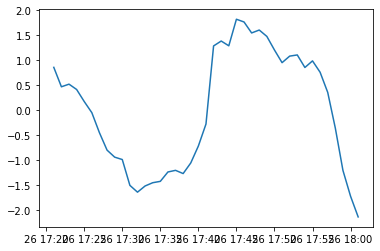

time
2020-04-26 17:02:00         NaN
2020-04-26 17:03:00         NaN
2020-04-26 17:04:00         NaN
2020-04-26 17:05:00         NaN
2020-04-26 17:06:00         NaN
2020-04-26 17:07:00         NaN
2020-04-26 17:08:00         NaN
2020-04-26 17:09:00         NaN
2020-04-26 17:10:00         NaN
2020-04-26 17:11:00         NaN
2020-04-26 17:12:00         NaN
2020-04-26 17:13:00         NaN
2020-04-26 17:14:00         NaN
2020-04-26 17:15:00         NaN
2020-04-26 17:16:00         NaN
2020-04-26 17:17:00         NaN
2020-04-26 17:18:00         NaN
2020-04-26 17:19:00         NaN
2020-04-26 17:20:00         NaN
2020-04-26 17:21:00   -1.070512
2020-04-26 17:22:00   -0.951734
2020-04-26 17:23:00   -1.031283
2020-04-26 17:24:00   -0.970344
2020-04-26 17:25:00   -0.748374
2020-04-26 17:26:00   -0.634357
2020-04-26 17:27:00    0.170598
2020-04-26 17:28:00    0.155857
2020-04-26 17:29:00    0.165386
2020-04-26 17:30:00    0.367884
2020-04-26 17:31:00   -0.122598
2020-04-26 17:32:00    0.045779
202

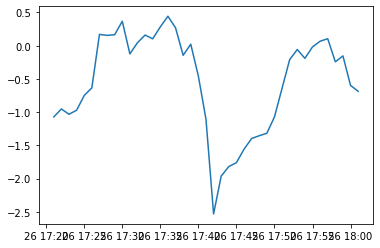

time
2020-04-26 17:02:00         NaN
2020-04-26 17:03:00         NaN
2020-04-26 17:04:00         NaN
2020-04-26 17:05:00         NaN
2020-04-26 17:06:00         NaN
2020-04-26 17:07:00         NaN
2020-04-26 17:08:00         NaN
2020-04-26 17:09:00         NaN
2020-04-26 17:10:00         NaN
2020-04-26 17:11:00         NaN
2020-04-26 17:12:00         NaN
2020-04-26 17:13:00         NaN
2020-04-26 17:14:00         NaN
2020-04-26 17:15:00         NaN
2020-04-26 17:16:00         NaN
2020-04-26 17:17:00         NaN
2020-04-26 17:18:00         NaN
2020-04-26 17:19:00         NaN
2020-04-26 17:20:00         NaN
2020-04-26 17:21:00   -0.944377
2020-04-26 17:22:00   -0.958073
2020-04-26 17:23:00   -0.980163
2020-04-26 17:24:00   -0.932038
2020-04-26 17:25:00   -0.789413
2020-04-26 17:26:00   -0.703462
2020-04-26 17:27:00   -0.058619
2020-04-26 17:28:00   -0.086655
2020-04-26 17:29:00   -0.068551
2020-04-26 17:30:00    0.105181
2020-04-26 17:31:00   -0.536840
2020-04-26 17:32:00   -0.517122
202

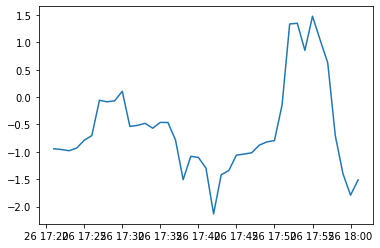

time
2020-04-26 17:02:00         NaN
2020-04-26 17:03:00         NaN
2020-04-26 17:04:00         NaN
2020-04-26 17:05:00         NaN
2020-04-26 17:06:00         NaN
2020-04-26 17:07:00         NaN
2020-04-26 17:08:00         NaN
2020-04-26 17:09:00         NaN
2020-04-26 17:10:00         NaN
2020-04-26 17:11:00         NaN
2020-04-26 17:12:00         NaN
2020-04-26 17:13:00         NaN
2020-04-26 17:14:00         NaN
2020-04-26 17:15:00         NaN
2020-04-26 17:16:00         NaN
2020-04-26 17:17:00         NaN
2020-04-26 17:18:00         NaN
2020-04-26 17:19:00         NaN
2020-04-26 17:20:00         NaN
2020-04-26 17:21:00    0.954185
2020-04-26 17:22:00    0.503742
2020-04-26 17:23:00    0.599135
2020-04-26 17:24:00    0.769464
2020-04-26 17:25:00    0.840873
2020-04-26 17:26:00    0.839385
2020-04-26 17:27:00   -0.034915
2020-04-26 17:28:00   -0.305344
2020-04-26 17:29:00   -0.254546
2020-04-26 17:30:00   -0.314241
2020-04-26 17:31:00   -0.633768
2020-04-26 17:32:00   -0.665485
202

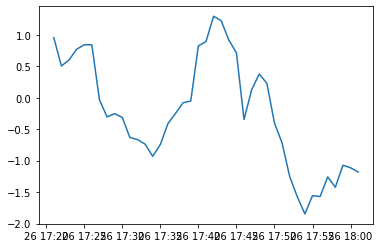

time
2020-04-26 17:02:00         NaN
2020-04-26 17:03:00         NaN
2020-04-26 17:04:00         NaN
2020-04-26 17:05:00         NaN
2020-04-26 17:06:00         NaN
2020-04-26 17:07:00         NaN
2020-04-26 17:08:00         NaN
2020-04-26 17:09:00         NaN
2020-04-26 17:10:00         NaN
2020-04-26 17:11:00         NaN
2020-04-26 17:12:00         NaN
2020-04-26 17:13:00         NaN
2020-04-26 17:14:00         NaN
2020-04-26 17:15:00         NaN
2020-04-26 17:16:00         NaN
2020-04-26 17:17:00         NaN
2020-04-26 17:18:00         NaN
2020-04-26 17:19:00         NaN
2020-04-26 17:20:00         NaN
2020-04-26 17:21:00   -0.159383
2020-04-26 17:22:00    0.565393
2020-04-26 17:23:00    0.632902
2020-04-26 17:24:00    0.745602
2020-04-26 17:25:00    0.718398
2020-04-26 17:26:00    0.654764
2020-04-26 17:27:00   -0.614914
2020-04-26 17:28:00   -0.697869
2020-04-26 17:29:00    1.244863
2020-04-26 17:30:00    1.174724
2020-04-26 17:31:00    0.336914
2020-04-26 17:32:00    1.135496
202

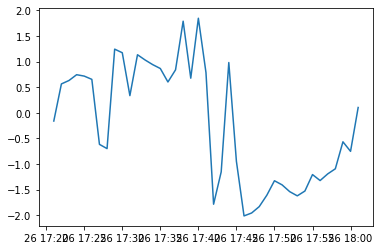

time
2020-04-26 17:02:00         NaN
2020-04-26 17:03:00         NaN
2020-04-26 17:04:00         NaN
2020-04-26 17:05:00         NaN
2020-04-26 17:06:00         NaN
2020-04-26 17:07:00         NaN
2020-04-26 17:08:00         NaN
2020-04-26 17:09:00         NaN
2020-04-26 17:10:00         NaN
2020-04-26 17:11:00         NaN
2020-04-26 17:12:00         NaN
2020-04-26 17:13:00         NaN
2020-04-26 17:14:00         NaN
2020-04-26 17:15:00         NaN
2020-04-26 17:16:00         NaN
2020-04-26 17:17:00         NaN
2020-04-26 17:18:00         NaN
2020-04-26 17:19:00         NaN
2020-04-26 17:20:00         NaN
2020-04-26 17:21:00   -0.975713
2020-04-26 17:22:00   -1.003483
2020-04-26 17:23:00   -0.935128
2020-04-26 17:24:00   -0.866168
2020-04-26 17:25:00   -0.549870
2020-04-26 17:26:00   -0.436958
2020-04-26 17:27:00    0.045502
2020-04-26 17:28:00   -0.036337
2020-04-26 17:29:00    0.014977
2020-04-26 17:30:00    0.310780
2020-04-26 17:31:00   -0.582063
2020-04-26 17:32:00   -0.440053
202

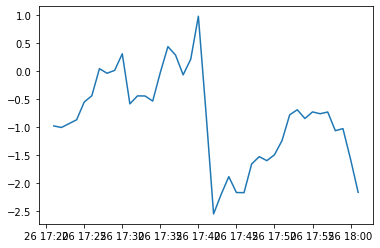

In [8]:
for symbol in symbols.keys():
    print(symbols[symbol].CCI)
    plt.plot(symbols[symbol].CCI)
    plt.show()

time
2020-04-26 17:02:00     True
2020-04-26 17:08:00     True
2020-04-26 17:15:00     True
2020-04-26 17:16:00    False
2020-04-26 17:18:00     True
2020-04-26 17:18:00     True
2020-04-26 17:18:00     True
2020-04-26 17:21:00    False
2020-04-26 17:27:00    False
2020-04-26 17:31:00    False
2020-04-26 17:48:00     True
Name: uptrend, dtype: bool


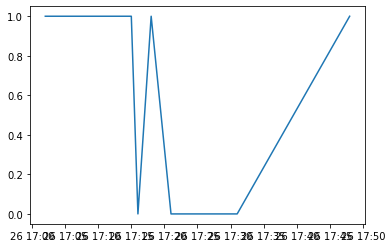

time
2020-04-26 17:02:00     True
2020-04-26 17:11:00     True
2020-04-26 17:16:00     True
2020-04-26 17:17:00    False
2020-04-26 17:17:00    False
2020-04-26 17:18:00    False
2020-04-26 17:18:00    False
2020-04-26 17:18:00    False
2020-04-26 17:21:00     True
2020-04-26 17:27:00     True
2020-04-26 17:27:00     True
2020-04-26 17:41:00    False
2020-04-26 17:42:00    False
Name: uptrend, dtype: bool


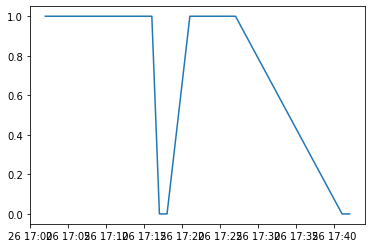

time
2020-04-26 17:02:00     True
2020-04-26 17:09:00     True
2020-04-26 17:11:00     True
2020-04-26 17:17:00    False
2020-04-26 17:18:00    False
2020-04-26 17:18:00    False
2020-04-26 17:27:00     True
2020-04-26 17:38:00    False
Name: uptrend, dtype: bool


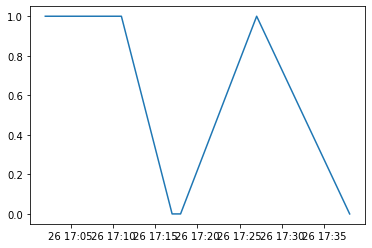

time
2020-04-26 17:02:00     True
2020-04-26 17:14:00    False
2020-04-26 17:16:00    False
2020-04-26 17:18:00     True
2020-04-26 17:18:00     True
2020-04-26 17:18:00     True
2020-04-26 17:31:00    False
2020-04-26 18:01:00    False
Name: uptrend, dtype: bool


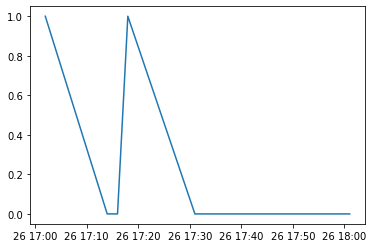

time
2020-04-26 17:02:00     True
2020-04-26 17:05:00    False
2020-04-26 17:12:00    False
2020-04-26 17:14:00    False
2020-04-26 17:20:00     True
2020-04-26 17:37:00     True
2020-04-26 17:42:00    False
2020-04-26 17:44:00     True
2020-04-26 17:45:00    False
2020-04-26 17:46:00    False
2020-04-26 17:53:00    False
Name: uptrend, dtype: bool


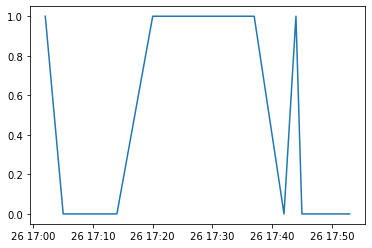

time
2020-04-26 17:02:00     True
2020-04-26 17:17:00    False
2020-04-26 17:18:00    False
2020-04-26 17:18:00    False
2020-04-26 17:21:00     True
2020-04-26 17:49:00    False
Name: uptrend, dtype: bool


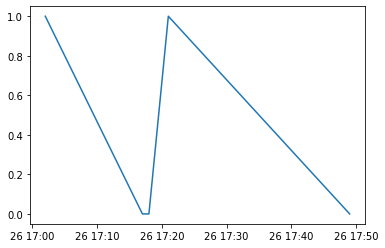

In [9]:
for symbol in symbols.keys():
    print(symbols[symbol].renko)
    plt.plot(symbols[symbol].renko)
    plt.show()

time
2020-04-26 17:28:00    0.139637
2020-04-26 17:29:00    0.151230
2020-04-26 17:30:00    0.185162
2020-04-26 17:31:00    0.223372
2020-04-26 17:32:00    0.257984
2020-04-26 17:33:00    0.287280
2020-04-26 17:34:00    0.319065
2020-04-26 17:35:00    0.346136
2020-04-26 17:36:00    0.373854
2020-04-26 17:37:00    0.403515
2020-04-26 17:38:00    0.412416
2020-04-26 17:39:00    0.378327
2020-04-26 17:40:00    0.340202
2020-04-26 17:41:00    0.371403
2020-04-26 17:42:00    0.398277
2020-04-26 17:43:00    0.415212
2020-04-26 17:44:00    0.446111
2020-04-26 17:45:00    0.472784
2020-04-26 17:46:00    0.485180
2020-04-26 17:47:00    0.503433
2020-04-26 17:48:00    0.521901
2020-04-26 17:49:00    0.513950
2020-04-26 17:50:00    0.476036
2020-04-26 17:51:00    0.457615
2020-04-26 17:52:00    0.457737
2020-04-26 17:53:00    0.444039
2020-04-26 17:54:00    0.447982
2020-04-26 17:55:00    0.444103
2020-04-26 17:56:00    0.410163
2020-04-26 17:57:00    0.371299
2020-04-26 17:58:00    0.362262
202

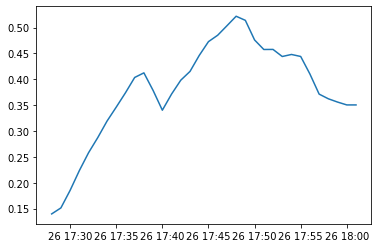

time
2020-04-26 17:28:00    0.290370
2020-04-26 17:29:00    0.301562
2020-04-26 17:30:00    0.261322
2020-04-26 17:31:00    0.227559
2020-04-26 17:32:00    0.199096
2020-04-26 17:33:00    0.184955
2020-04-26 17:34:00    0.172945
2020-04-26 17:35:00    0.162716
2020-04-26 17:36:00    0.174042
2020-04-26 17:37:00    0.192131
2020-04-26 17:38:00    0.184316
2020-04-26 17:39:00    0.177608
2020-04-26 17:40:00    0.194846
2020-04-26 17:41:00    0.255685
2020-04-26 17:42:00    0.308088
2020-04-26 17:43:00    0.353264
2020-04-26 17:44:00    0.400487
2020-04-26 17:45:00    0.441252
2020-04-26 17:46:00    0.476460
2020-04-26 17:47:00    0.512966
2020-04-26 17:48:00    0.544524
2020-04-26 17:49:00    0.571813
2020-04-26 17:50:00    0.544986
2020-04-26 17:51:00    0.486687
2020-04-26 17:52:00    0.436235
2020-04-26 17:53:00    0.401015
2020-04-26 17:54:00    0.353547
2020-04-26 17:55:00    0.312448
2020-04-26 17:56:00    0.288255
2020-04-26 17:57:00    0.294087
2020-04-26 17:58:00    0.299139
202

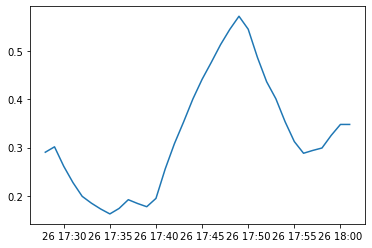

time
2020-04-26 17:28:00    0.270016
2020-04-26 17:29:00    0.270087
2020-04-26 17:30:00    0.255333
2020-04-26 17:31:00    0.242955
2020-04-26 17:32:00    0.232520
2020-04-26 17:33:00    0.233818
2020-04-26 17:34:00    0.234920
2020-04-26 17:35:00    0.235859
2020-04-26 17:36:00    0.256876
2020-04-26 17:37:00    0.282446
2020-04-26 17:38:00    0.274006
2020-04-26 17:39:00    0.266761
2020-04-26 17:40:00    0.275203
2020-04-26 17:41:00    0.317528
2020-04-26 17:42:00    0.345471
2020-04-26 17:43:00    0.369559
2020-04-26 17:44:00    0.360268
2020-04-26 17:45:00    0.352247
2020-04-26 17:46:00    0.345319
2020-04-26 17:47:00    0.356569
2020-04-26 17:48:00    0.363220
2020-04-26 17:49:00    0.371812
2020-04-26 17:50:00    0.336483
2020-04-26 17:51:00    0.328570
2020-04-26 17:52:00    0.321723
2020-04-26 17:53:00    0.282737
2020-04-26 17:54:00    0.262778
2020-04-26 17:55:00    0.238830
2020-04-26 17:56:00    0.209072
2020-04-26 17:57:00    0.228929
2020-04-26 17:58:00    0.254408
202

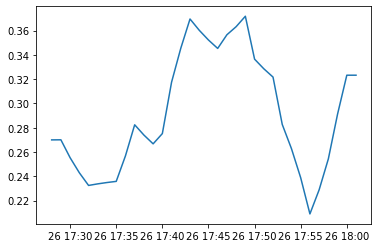

time
2020-04-26 17:28:00    0.206480
2020-04-26 17:29:00    0.206030
2020-04-26 17:30:00    0.233598
2020-04-26 17:31:00    0.264847
2020-04-26 17:32:00    0.291191
2020-04-26 17:33:00    0.314836
2020-04-26 17:34:00    0.295520
2020-04-26 17:35:00    0.268420
2020-04-26 17:36:00    0.256339
2020-04-26 17:37:00    0.249728
2020-04-26 17:38:00    0.255206
2020-04-26 17:39:00    0.275916
2020-04-26 17:40:00    0.293716
2020-04-26 17:41:00    0.332773
2020-04-26 17:42:00    0.366414
2020-04-26 17:43:00    0.375449
2020-04-26 17:44:00    0.343483
2020-04-26 17:45:00    0.320293
2020-04-26 17:46:00    0.285998
2020-04-26 17:47:00    0.256364
2020-04-26 17:48:00    0.230748
2020-04-26 17:49:00    0.239284
2020-04-26 17:50:00    0.258374
2020-04-26 17:51:00    0.279668
2020-04-26 17:52:00    0.313398
2020-04-26 17:53:00    0.342593
2020-04-26 17:54:00    0.363118
2020-04-26 17:55:00    0.380891
2020-04-26 17:56:00    0.396281
2020-04-26 17:57:00    0.416109
2020-04-26 17:58:00    0.419022
202

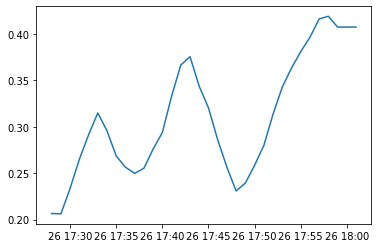

time
2020-04-26 17:28:00    0.206449
2020-04-26 17:29:00    0.201615
2020-04-26 17:30:00    0.182664
2020-04-26 17:31:00    0.175327
2020-04-26 17:32:00    0.169142
2020-04-26 17:33:00    0.163907
2020-04-26 17:34:00    0.159462
2020-04-26 17:35:00    0.153209
2020-04-26 17:36:00    0.144285
2020-04-26 17:37:00    0.137533
2020-04-26 17:38:00    0.133614
2020-04-26 17:39:00    0.131659
2020-04-26 17:40:00    0.135546
2020-04-26 17:41:00    0.176867
2020-04-26 17:42:00    0.206451
2020-04-26 17:43:00    0.181174
2020-04-26 17:44:00    0.198020
2020-04-26 17:45:00    0.220051
2020-04-26 17:46:00    0.239078
2020-04-26 17:47:00    0.254744
2020-04-26 17:48:00    0.268497
2020-04-26 17:49:00    0.263204
2020-04-26 17:50:00    0.263826
2020-04-26 17:51:00    0.279820
2020-04-26 17:52:00    0.296654
2020-04-26 17:53:00    0.316167
2020-04-26 17:54:00    0.284163
2020-04-26 17:55:00    0.256452
2020-04-26 17:56:00    0.232456
2020-04-26 17:57:00    0.210439
2020-04-26 17:58:00    0.237816
202

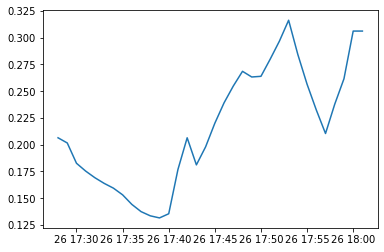

time
2020-04-26 17:28:00    0.255885
2020-04-26 17:29:00    0.259268
2020-04-26 17:30:00    0.256080
2020-04-26 17:31:00    0.253405
2020-04-26 17:32:00    0.251150
2020-04-26 17:33:00    0.261442
2020-04-26 17:34:00    0.246735
2020-04-26 17:35:00    0.227148
2020-04-26 17:36:00    0.220973
2020-04-26 17:37:00    0.218828
2020-04-26 17:38:00    0.207221
2020-04-26 17:39:00    0.189958
2020-04-26 17:40:00    0.192271
2020-04-26 17:41:00    0.234299
2020-04-26 17:42:00    0.270499
2020-04-26 17:43:00    0.301707
2020-04-26 17:44:00    0.351787
2020-04-26 17:45:00    0.395018
2020-04-26 17:46:00    0.421221
2020-04-26 17:47:00    0.444195
2020-04-26 17:48:00    0.464584
2020-04-26 17:49:00    0.482215
2020-04-26 17:50:00    0.497465
2020-04-26 17:51:00    0.460423
2020-04-26 17:52:00    0.428366
2020-04-26 17:53:00    0.419266
2020-04-26 17:54:00    0.411389
2020-04-26 17:55:00    0.405169
2020-04-26 17:56:00    0.403927
2020-04-26 17:57:00    0.423510
2020-04-26 17:58:00    0.440471
202

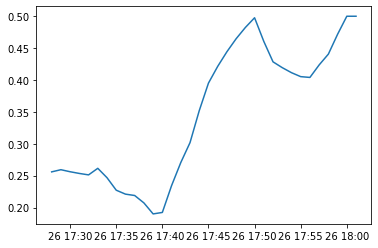

In [10]:
for symbol in symbols.keys():
    print(symbols[symbol].ADX)
    plt.plot(symbols[symbol].ADX)
    plt.show()

                             K          D           J
time                                                 
2020-04-26 17:02:00  36.000000  45.333333   17.333333
2020-04-26 17:03:00  30.666667  40.444444   11.111111
2020-04-26 17:04:00  27.282051  36.056980    9.732194
2020-04-26 17:05:00  36.991453  36.368471   38.237417
2020-04-26 17:06:00  46.883191  39.873378   60.902817
2020-04-26 17:07:00  45.785375  41.844043   53.668038
2020-04-26 17:08:00  63.856917  49.181668   93.207414
2020-04-26 17:09:00  69.494355  55.952564   96.577937
2020-04-26 17:10:00  57.868031  56.591053   60.421989
2020-04-26 17:11:00  48.194072  53.792059   36.998098
2020-04-26 17:12:00  44.308869  50.630996   31.664614
2020-04-26 17:13:00  44.122579  48.461524   35.444690
2020-04-26 17:14:00  44.632444  47.185164   39.527005
2020-04-26 17:15:00  62.567463  52.312597   83.077195
2020-04-26 17:16:00  43.298943  49.308046   31.280739
2020-04-26 17:17:00  47.869078  48.828390   45.950453
2020-04-26 17:18:00  60.2181

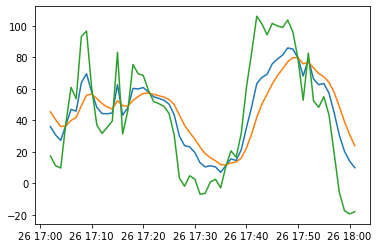

                             K          D           J
time                                                 
2020-04-26 17:02:00  39.142857  46.380952   24.666667
2020-04-26 17:03:00  34.224454  42.328786   18.015788
2020-04-26 17:04:00  28.830703  37.829425   10.833259
2020-04-26 17:05:00  24.832498  33.497116    7.503261
2020-04-26 17:06:00  25.873084  30.955772   15.707708
2020-04-26 17:07:00  23.187617  28.366387   12.830078
2020-04-26 17:08:00  25.362291  27.365022   21.356829
2020-04-26 17:09:00  41.642145  32.124063   60.678310
2020-04-26 17:10:00  52.834124  39.027416   80.447538
2020-04-26 17:11:00  63.012764  47.022532   94.993227
2020-04-26 17:12:00  68.917467  54.320844   98.110713
2020-04-26 17:13:00  72.284919  60.308869   96.237019
2020-04-26 17:14:00  68.096334  62.904690   78.479620
2020-04-26 17:15:00  69.342123  65.050501   77.925366
2020-04-26 17:16:00  73.068061  67.723021   83.758140
2020-04-26 17:17:00  52.317165  62.587736   31.776023
2020-04-26 17:18:00  41.6158

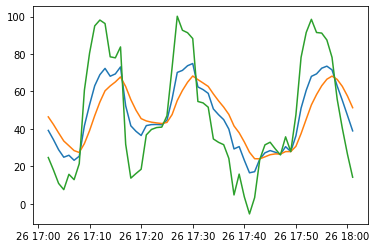

                             K          D           J
time                                                 
2020-04-26 17:02:00  35.294118  45.098039   15.686275
2020-04-26 17:03:00  27.450980  39.215686    3.921569
2020-04-26 17:04:00  21.475257  33.302210   -2.178649
2020-04-26 17:05:00  22.253346  29.619255    7.521527
2020-04-26 17:06:00  26.475775  28.571429   22.284469
2020-04-26 17:07:00  19.237819  25.460225    6.793005
2020-04-26 17:08:00  30.814630  27.245027   37.953837
2020-04-26 17:09:00  44.352611  32.947555   67.162722
2020-04-26 17:10:00  54.436132  40.110414   83.087568
2020-04-26 17:11:00  69.217584  49.812804  108.027144
2020-04-26 17:12:00  77.445869  59.023826  114.289956
2020-04-26 17:13:00  83.276149  67.107933  115.612580
2020-04-26 17:14:00  80.411947  71.542605   98.150633
2020-04-26 17:15:00  86.274632  76.453280  105.917334
2020-04-26 17:16:00  82.166281  78.357614   89.783615
2020-04-26 17:17:00  61.619626  72.778285   39.302309
2020-04-26 17:18:00  51.9771

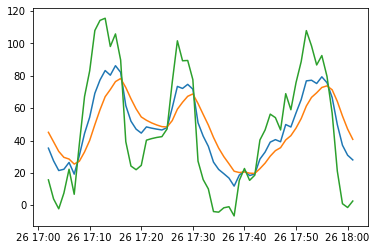

                             K          D           J
time                                                 
2020-04-26 17:02:00  66.666667  55.555556   88.888889
2020-04-26 17:03:00  77.777778  62.962963  107.407407
2020-04-26 17:04:00  59.603790  61.843239   55.124892
2020-04-26 17:05:00  50.605425  58.097301   35.621674
2020-04-26 17:06:00  42.432602  52.875735   21.546338
2020-04-26 17:07:00  38.433329  48.061599   19.176788
2020-04-26 17:08:00  38.665698  44.929632   26.137829
2020-04-26 17:09:00  33.748146  41.202470   18.839498
2020-04-26 17:10:00  29.843397  37.416112   14.697966
2020-04-26 17:11:00  19.895598  31.575941   -3.465088
2020-04-26 17:12:00  21.597065  28.249649    8.291898
2020-04-26 17:13:00  19.953599  25.484299    8.892199
2020-04-26 17:14:00  15.717858  22.228819    2.695937
2020-04-26 17:15:00  18.929276  21.128971   14.529887
2020-04-26 17:16:00  15.313120  19.190354    7.558652
2020-04-26 17:17:00  25.855005  21.411905   34.741207
2020-04-26 17:18:00  48.3913

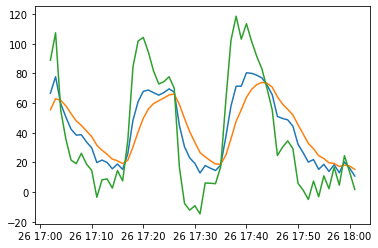

                             K          D           J
time                                                 
2020-04-26 17:02:00  33.333333  44.444444   11.111111
2020-04-26 17:03:00  55.555556  48.148148   70.370370
2020-04-26 17:04:00  70.370370  55.555556  100.000000
2020-04-26 17:05:00  46.913580  52.674897   35.390947
2020-04-26 17:06:00  50.369571  51.906455   47.295804
2020-04-26 17:07:00  33.579714  45.797542    9.144060
2020-04-26 17:08:00  40.671266  44.088783   33.836231
2020-04-26 17:09:00  27.114177  38.430581    4.481370
2020-04-26 17:10:00  18.076118  31.645760   -9.063166
2020-04-26 17:11:00  23.513792  28.935104   12.671168
2020-04-26 17:12:00  15.675861  24.515357   -2.003129
2020-04-26 17:13:00  16.944081  21.991598    6.849046
2020-04-26 17:14:00  11.296054  18.426417   -2.964672
2020-04-26 17:15:00  20.588286  19.147040   23.470778
2020-04-26 17:16:00  26.620901  21.638327   36.586049
2020-04-26 17:17:00  22.984175  22.086943   24.778639
2020-04-26 17:18:00  22.6771

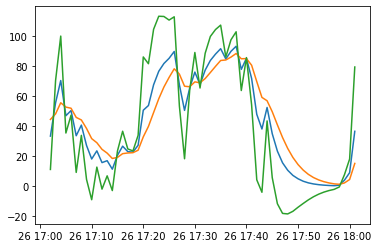

                             K          D           J
time                                                 
2020-04-26 17:02:00  66.064257  55.354752   87.483266
2020-04-26 17:03:00  57.824889  56.178131   61.118405
2020-04-26 17:04:00  38.772892  50.376385   15.565905
2020-04-26 17:05:00  31.589955  44.114241    6.541381
2020-04-26 17:06:00  29.086726  39.105069    9.050038
2020-04-26 17:07:00  24.853804  34.354647    5.852116
2020-04-26 17:08:00  27.438768  32.049354   18.217595
2020-04-26 17:09:00  23.699424  29.266044   12.566183
2020-04-26 17:10:00  31.964610  30.165566   35.562698
2020-04-26 17:11:00  47.476407  35.935846   70.557528
2020-04-26 17:12:00  58.150938  43.340877   87.771060
2020-04-26 17:13:00  55.767292  47.483015   72.335845
2020-04-26 17:14:00  40.172795  45.046275   30.425834
2020-04-26 17:15:00  46.418584  45.503711   48.248329
2020-04-26 17:16:00  49.011505  46.672976   53.688564
2020-04-26 17:17:00  34.157553  42.501168   17.470323
2020-04-26 17:18:00  29.9621

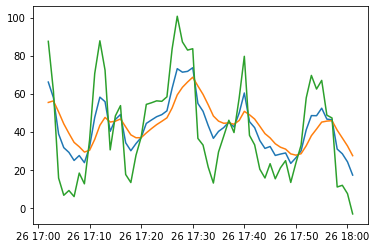

In [11]:
for symbol in symbols.keys():
    print(symbols[symbol].KDJ)
    plt.plot(symbols[symbol].KDJ)
    plt.show()

                             MACD   signal_line     histogram
time                                                         
2020-04-26 17:02:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-26 17:03:00  6.730769e-08  3.739316e-08  2.991453e-08
2020-04-26 17:04:00 -2.553460e-07 -8.258190e-08 -1.727641e-07
2020-04-26 17:05:00  1.096274e-07 -1.747036e-08  1.270977e-07
2020-04-26 17:06:00  4.648097e-07  1.259970e-07  3.388126e-07
2020-04-26 17:07:00  2.847403e-07  1.690253e-07  1.157150e-07
2020-04-26 17:08:00  1.478104e-06  5.003183e-07  9.777861e-07
2020-04-26 17:09:00  2.064286e-06  8.761692e-07  1.188117e-06
2020-04-26 17:10:00  1.248070e-06  9.620802e-07  2.859899e-07
2020-04-26 17:11:00  4.963821e-07  8.577368e-07 -3.613547e-07
2020-04-26 17:12:00  1.593413e-07  7.049318e-07 -5.455905e-07
2020-04-26 17:13:00  2.396579e-07  6.050105e-07 -3.653526e-07
2020-04-26 17:14:00  4.090200e-07  5.635321e-07 -1.545121e-07
2020-04-26 17:15:00  2.964637e-06  1.065845e-06  1.898792e-06
2020-04-

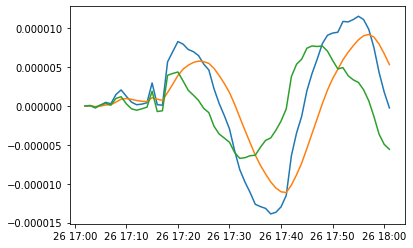

                         MACD  signal_line  histogram
time                                                 
2020-04-26 17:02:00  0.000000     0.000000   0.000000
2020-04-26 17:03:00 -0.029615    -0.016453  -0.013162
2020-04-26 17:04:00 -0.217594    -0.098888  -0.118706
2020-04-26 17:05:00 -0.304617    -0.168579  -0.136038
2020-04-26 17:06:00 -0.275855    -0.200491  -0.075363
2020-04-26 17:07:00 -0.450933    -0.268375  -0.182558
2020-04-26 17:08:00 -0.450799    -0.314542  -0.136257
2020-04-26 17:09:00 -0.032544    -0.246772   0.214228
2020-04-26 17:10:00  0.483823    -0.078001   0.561824
2020-04-26 17:11:00  1.425652     0.258905   1.166747
2020-04-26 17:12:00  2.035094     0.647525   1.387569
2020-04-26 17:13:00  2.420162     1.028213   1.391949
2020-04-26 17:14:00  2.277653     1.292638   0.985015
2020-04-26 17:15:00  2.396408     1.523547   0.872860
2020-04-26 17:16:00  3.776335     1.990536   1.785800
2020-04-26 17:17:00  1.282530     1.844833  -0.562303
2020-04-26 17:18:00 -3.70535

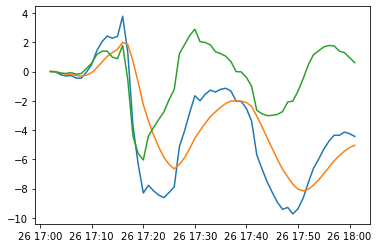

                         MACD  signal_line  histogram
time                                                 
2020-04-26 17:02:00  0.000000     0.000000   0.000000
2020-04-26 17:03:00  0.000449     0.000249   0.000199
2020-04-26 17:04:00 -0.007801    -0.003050  -0.004751
2020-04-26 17:05:00 -0.008112    -0.004765  -0.003348
2020-04-26 17:06:00 -0.005325    -0.004932  -0.000394
2020-04-26 17:07:00 -0.011675    -0.006759  -0.004915
2020-04-26 17:08:00 -0.001502    -0.005429   0.003927
2020-04-26 17:09:00  0.010575    -0.001583   0.012158
2020-04-26 17:10:00  0.019770     0.003350   0.016420
2020-04-26 17:11:00  0.043518     0.012350   0.031168
2020-04-26 17:12:00  0.057937     0.022324   0.035613
2020-04-26 17:13:00  0.068269     0.032191   0.036078
2020-04-26 17:14:00  0.065989     0.039344   0.026645
2020-04-26 17:15:00  0.086027     0.049110   0.036917
2020-04-26 17:16:00  0.097668     0.059176   0.038492
2020-04-26 17:17:00  0.032494     0.053685  -0.021191
2020-04-26 17:18:00 -0.05412

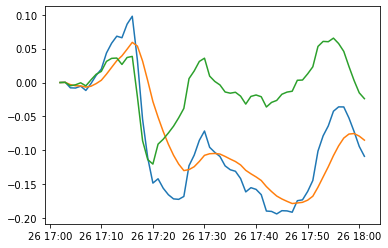

                             MACD   signal_line     histogram
time                                                         
2020-04-26 17:02:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-26 17:03:00  1.121795e-08  6.232194e-09  4.985755e-09
2020-04-26 17:04:00 -6.943295e-08 -2.477811e-08 -4.465484e-08
2020-04-26 17:05:00 -9.719200e-08 -4.930856e-08 -4.788344e-08
2020-04-26 17:06:00 -1.221674e-07 -7.098242e-08 -5.118499e-08
2020-04-26 17:07:00 -1.263326e-07 -8.598539e-08 -4.034718e-08
2020-04-26 17:08:00 -1.087070e-07 -9.173563e-08 -1.697138e-08
2020-04-26 17:09:00 -1.284325e-07 -1.005546e-07 -2.787795e-08
2020-04-26 17:10:00 -1.947129e-07 -1.223056e-07 -7.240731e-08
2020-04-26 17:11:00 -3.110107e-07 -1.645865e-07 -1.464242e-07
2020-04-26 17:12:00 -3.747050e-07 -2.105592e-07 -1.641457e-07
2020-04-26 17:13:00 -4.987011e-07 -2.724400e-07 -2.262611e-07
2020-04-26 17:14:00 -6.913720e-07 -3.611006e-07 -3.302714e-07
2020-04-26 17:15:00 -7.628575e-07 -4.451484e-07 -3.177091e-07
2020-04-

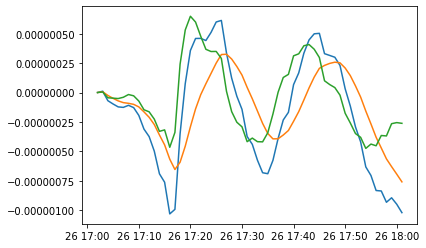

                             MACD   signal_line     histogram
time                                                         
2020-04-26 17:02:00  0.000000e+00  0.000000e+00  0.000000e+00
2020-04-26 17:03:00  4.487179e-07  2.492877e-07  1.994302e-07
2020-04-26 17:04:00  5.717557e-07  3.814468e-07  1.903090e-07
2020-04-26 17:05:00 -6.823848e-06 -2.059371e-06 -4.764477e-06
2020-04-26 17:06:00 -6.003358e-06 -3.232618e-06 -2.770740e-06
2020-04-26 17:07:00 -1.044304e-05 -5.187043e-06 -5.255995e-06
2020-04-26 17:08:00 -7.991280e-06 -5.896720e-06 -2.094559e-06
2020-04-26 17:09:00 -1.159307e-05 -7.265660e-06 -4.327410e-06
2020-04-26 17:10:00 -1.465505e-05 -8.972647e-06 -5.682406e-06
2020-04-26 17:11:00 -1.269922e-05 -9.807615e-06 -2.891602e-06
2020-04-26 17:12:00 -1.941879e-05 -1.191049e-05 -7.508307e-06
2020-04-26 17:13:00 -2.232327e-05 -1.414671e-05 -8.176554e-06
2020-04-26 17:14:00 -3.333226e-05 -1.820704e-05 -1.512522e-05
2020-04-26 17:15:00 -3.546002e-05 -2.181638e-05 -1.364364e-05
2020-04-

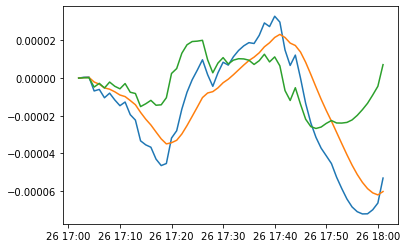

                         MACD  signal_line  histogram
time                                                 
2020-04-26 17:02:00  0.000000     0.000000   0.000000
2020-04-26 17:03:00 -0.000173    -0.000096  -0.000077
2020-04-26 17:04:00 -0.001684    -0.000747  -0.000937
2020-04-26 17:05:00 -0.001972    -0.001162  -0.000810
2020-04-26 17:06:00 -0.001924    -0.001389  -0.000536
2020-04-26 17:07:00 -0.002056    -0.001570  -0.000487
2020-04-26 17:08:00 -0.001666    -0.001594  -0.000072
2020-04-26 17:09:00 -0.001843    -0.001654  -0.000189
2020-04-26 17:10:00 -0.000981    -0.001498   0.000518
2020-04-26 17:11:00  0.000578    -0.001033   0.001611
2020-04-26 17:12:00  0.001728    -0.000429   0.002157
2020-04-26 17:13:00  0.001608     0.000008   0.001600
2020-04-26 17:14:00 -0.000332    -0.000064  -0.000268
2020-04-26 17:15:00  0.000185    -0.000012   0.000196
2020-04-26 17:16:00  0.000382     0.000070   0.000312
2020-04-26 17:17:00 -0.005010    -0.000976  -0.004035
2020-04-26 17:18:00 -0.01167

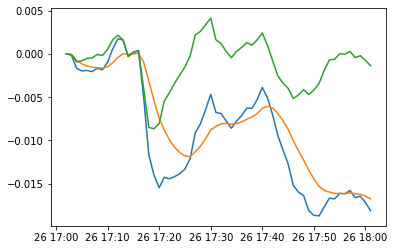

In [12]:
for symbol in symbols.keys():
    print(symbols[symbol].MACD)
    plt.plot(symbols[symbol].MACD)
    plt.show()

                         open      high       low     close   volume  \
time                                                                   
2020-04-26 17:40:00  0.025549  0.025556  0.025541  0.025547   40.657   
2020-04-26 17:41:00  0.025549  0.025567  0.025549  0.025557    4.681   
2020-04-26 17:42:00  0.025567  0.025613  0.025567  0.025607  150.200   
2020-04-26 17:43:00  0.025598  0.025607  0.025592  0.025592   23.386   
2020-04-26 17:44:00  0.025592  0.025600  0.025590  0.025590   57.370   
2020-04-26 17:45:00  0.025597  0.025620  0.025593  0.025610   60.627   
2020-04-26 17:46:00  0.025617  0.025618  0.025604  0.025606   54.516   
2020-04-26 17:47:00  0.025606  0.025612  0.025601  0.025608   51.010   
2020-04-26 17:48:00  0.025605  0.025620  0.025605  0.025616   36.076   
2020-04-26 17:49:00  0.025612  0.025623  0.025611  0.025611   49.522   
2020-04-26 17:50:00  0.025619  0.025621  0.025605  0.025605   71.016   
2020-04-26 17:51:00  0.025615  0.025615  0.025596  0.025605  267

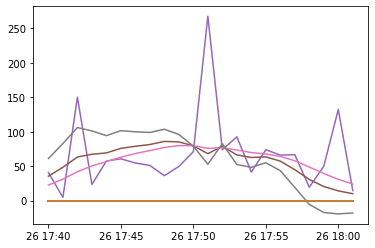

                        open     high      low    close      volume  \
time                                                                  
2020-04-26 17:40:00  7720.58  7721.29  7714.18  7714.27   36.908150   
2020-04-26 17:41:00  7715.70  7716.11  7706.83  7707.54   70.152501   
2020-04-26 17:42:00  7707.50  7707.50  7676.00  7685.79  302.236616   
2020-04-26 17:43:00  7685.79  7699.95  7685.79  7696.00   76.856063   
2020-04-26 17:44:00  7696.00  7697.72  7689.49  7693.16   68.232182   
2020-04-26 17:45:00  7692.59  7700.99  7681.00  7691.62  219.555189   
2020-04-26 17:46:00  7690.64  7700.11  7685.67  7689.03  100.959682   
2020-04-26 17:47:00  7689.03  7700.00  7686.42  7688.23   57.410553   
2020-04-26 17:48:00  7688.16  7695.00  7680.60  7693.51   60.977655   
2020-04-26 17:49:00  7694.18  7694.18  7684.61  7685.07   29.800683   
2020-04-26 17:50:00  7685.11  7694.17  7685.00  7692.72   21.427259   
2020-04-26 17:51:00  7692.54  7701.00  7690.96  7697.03   53.601295   
2020-0

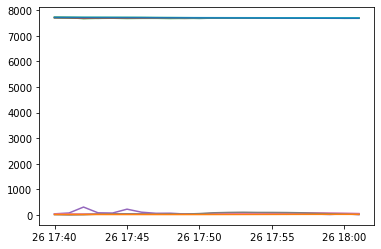

                       open    high     low   close      volume          K  \
time                                                                         
2020-04-26 17:40:00  197.24  197.25  197.13  197.13   181.64365  21.299781   
2020-04-26 17:41:00  197.10  197.23  197.02  197.03   378.18820  18.366521   
2020-04-26 17:42:00  197.01  197.01  196.59  196.77  1326.49485  19.303171   
2020-04-26 17:43:00  196.78  197.05  196.78  196.98   712.55475  28.531431   
2020-04-26 17:44:00  196.95  197.01  196.83  196.91   398.90165  32.873768   
2020-04-26 17:45:00  196.90  197.14  196.79  196.98  2322.26098  39.021108   
2020-04-26 17:46:00  197.00  197.10  196.83  196.90  1659.13675  40.568063   
2020-04-26 17:47:00  196.90  197.09  196.83  196.85   419.70764  39.251948   
2020-04-26 17:48:00  196.85  197.07  196.70  197.06   446.83715  49.905339   
2020-04-26 17:49:00  197.07  197.08  196.87  196.88   335.64431  48.374393   
2020-04-26 17:50:00  196.89  197.00  196.85  197.00   113.38452 

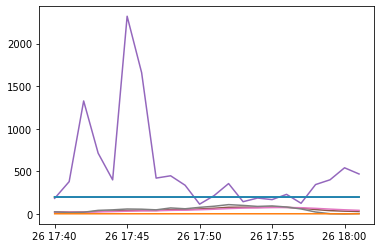

                         open      high       low     close   volume  \
time                                                                   
2020-04-26 17:40:00  0.002133  0.002135  0.002133  0.002135   819.71   
2020-04-26 17:41:00  0.002135  0.002135  0.002134  0.002134   283.83   
2020-04-26 17:42:00  0.002134  0.002137  0.002133  0.002135  1541.95   
2020-04-26 17:43:00  0.002136  0.002136  0.002134  0.002135   362.80   
2020-04-26 17:44:00  0.002134  0.002135  0.002133  0.002134   618.47   
2020-04-26 17:45:00  0.002135  0.002135  0.002132  0.002134   549.19   
2020-04-26 17:46:00  0.002133  0.002133  0.002130  0.002132  1293.06   
2020-04-26 17:47:00  0.002132  0.002133  0.002131  0.002133   812.86   
2020-04-26 17:48:00  0.002133  0.002133  0.002132  0.002133   872.73   
2020-04-26 17:49:00  0.002133  0.002133  0.002132  0.002133   561.21   
2020-04-26 17:50:00  0.002132  0.002133  0.002131  0.002131   606.82   
2020-04-26 17:51:00  0.002131  0.002133  0.002130  0.002131   50

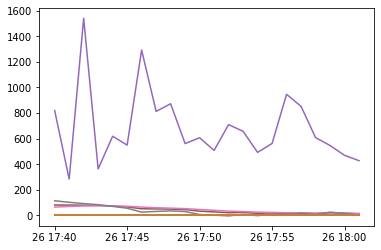

                         open      high       low     close  volume  \
time                                                                  
2020-04-26 17:40:00  0.083524  0.083525  0.083524  0.083525  168.55   
2020-04-26 17:41:00  0.083525  0.083525  0.083433  0.083433   30.37   
2020-04-26 17:42:00  0.083310  0.083310  0.083276  0.083276   61.81   
2020-04-26 17:43:00  0.083323  0.083323  0.083322  0.083322   24.96   
2020-04-26 17:44:00  0.083478  0.083478  0.083478  0.083478    0.03   
2020-04-26 17:45:00  0.083466  0.083466  0.083266  0.083266   93.52   
2020-04-26 17:46:00  0.083242  0.083242  0.083216  0.083216   10.03   
2020-04-26 17:47:00  0.083216  0.083216  0.083216  0.083216    0.00   
2020-04-26 17:48:00  0.083218  0.083218  0.083218  0.083218   10.59   
2020-04-26 17:49:00  0.083217  0.083217  0.083217  0.083217    2.53   
2020-04-26 17:50:00  0.083254  0.083254  0.083217  0.083217   68.28   
2020-04-26 17:51:00  0.083217  0.083217  0.083199  0.083199  108.14   
2020-0

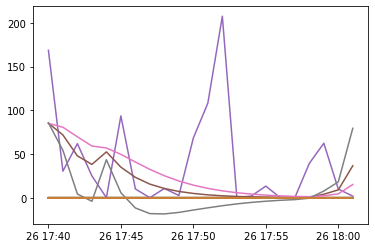

                        open     high      low    close   volume          K  \
time                                                                          
2020-04-26 17:40:00  16.4697  16.4876  16.4697  16.4768  1916.98  60.325573   
2020-04-26 17:41:00  16.4764  16.4764  16.4462  16.4462  1120.73  45.271693   
2020-04-26 17:42:00  16.4400  16.4400  16.4012  16.4321  6176.33  42.102425   
2020-04-26 17:43:00  16.4269  16.4369  16.4120  16.4200  2990.28  35.321370   
2020-04-26 17:44:00  16.4298  16.4298  16.4195  16.4210   160.04  31.186469   
2020-04-26 17:45:00  16.4201  16.4303  16.3782  16.4156  3333.48  32.186470   
2020-04-26 17:46:00  16.4082  16.4125  16.3793  16.3980  2470.56  27.490553   
2020-04-26 17:47:00  16.3926  16.4172  16.3852  16.4106  2585.64  28.199065   
2020-04-26 17:48:00  16.4064  16.4123  16.3847  16.4110  1704.37  28.793283   
2020-04-26 17:49:00  16.4103  16.4103  16.3840  16.3903   710.37  23.302786   
2020-04-26 17:50:00  16.3903  16.4000  16.3841  16.3

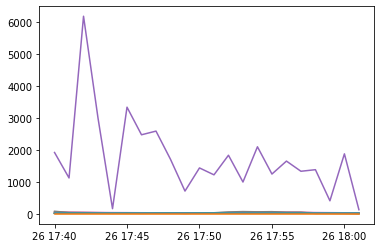

In [13]:
for symbol in symbols.keys():
    print(symbols[symbol].bollinger_bands)
    plt.plot(symbols[symbol].bollinger_bands)
    plt.show()

In [ ]:
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([[msg['o'].rstrip('0').rstrip('.'), 
                           msg['h'].rstrip('0').rstrip('.'), 
                           msg['l'].rstrip('0').rstrip('.'), 
                           msg['c'].rstrip('0').rstrip('.'), 
                           msg['v'].rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].trend_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].trend_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()

scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 'buy'})
    scores.update({crypto_pair.quote_asset: 'buy'})

temp_scores = {}
for crypto_pair in symbols.values():
    temp_scores.update({crypto_pair.base_asset: 0})
    temp_scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(10)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    temp_scores = {}
    for crypto_pair in symbols.values():
        temp_scores.update({crypto_pair.base_asset: 0})
        temp_scores.update({crypto_pair.quote_asset: 0})

    for asset in temp_scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].volatility_trigger.iloc[-1]:
                    temp_scores.update({asset: temp_scores[asset] + 1})
                else:
                    temp_scores.update({asset: temp_scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].trend_trigger.iloc[-1] and \
                        symbols[symbol].volatility_trigger.iloc[-1]:
                    temp_scores.update({asset: temp_scores[asset] - 1})
                else:
                    temp_scores.update({asset: temp_scores[asset] + 1})

    assets = temp_scores.keys()
    buy_assets = [asset for asset in temp_scores.keys() if temp_scores[asset] == len(scores.keys())]
    sell_assets = [asset for asset in temp_scores.keys() if temp_scores[asset] == -len(scores.keys())]

    for asset in scores.keys():
        if asset in buy_assets:
            scores[asset] = 'buy'
        elif asset in sell_assets:
            scores[asset] = 'sell'

    buy_assets = list()
    sell_assets = list()

    for asset in scores.keys():
        if scores[asset] == 'buy':
            buy_assets.append(asset)
        elif scores[asset] == 'sell':
            sell_assets.append(asset)

    print('buy_assets: ', buy_assets)
    print('sell_assets: ', sell_assets)

    if scores[symbols[symbol].base_asset] == 'sell' and \
            scores[symbols[symbol].base_asset] == 'sell':

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in buy_assets])]

        target_symbol = random.choice(target_symbols)
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol

buy_assets:  ['ETH', 'BTC', 'USDT', 'BNB']
sell_assets:  []
buy_assets:  ['ETH', 'BTC', 'USDT', 'BNB']
sell_assets:  []
buy_assets:  ['ETH', 'BTC', 'USDT', 'BNB']
sell_assets:  []


In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()